In [1]:
import numpy as np
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt

from datasets import (load_direct_and_indirect_pairs,
                      load_sys_nb,
                      load_tarassov,
                      load_Y2H_union_25,
                      load_lit_24, 
                      load_ho,
                      load_gi_pcc_values)
from plotting import (savefig,
                      COLOR_Y2H,
                      COLOR_SYS_NB,
                      COLOR_LIT,
                      COLOR_LIT_NB,
                      COLOR_GI_PSN)

In [2]:
# the ipython matplotlib inline display overrides the rcParams
# that used to be called on the pyplot import but now seems like
# it's called on the first use of inline figures or something 
# problem is in ipython: https://github.com/ipython/ipython/issues/10383
# should be fixed soon: https://github.com/ipython/matplotlib-inline/pull/14
plt.show()
mpl.rcParams['font.size'] = 7.
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['savefig.dpi'] = 500

In [3]:
df = load_direct_and_indirect_pairs()
abbi = load_Y2H_union_25(remove_homodimers=True)
sysnb = load_sys_nb(remove_homodimers=True)
ho = load_ho(remove_homodimers=True)
tarassov = load_tarassov(remove_homodimers=True)
lit = load_lit_24(remove_homodimers=True)
gi_pcc = load_gi_pcc_values()
nws = {
       'Lit-CC-24': lit.loc[lit['category'] == 'Lit-NB', ].index,
       'Lit-BS-24': lit.loc[lit['category'] == 'Lit-BS', ].index,
       'Lit-BM-24': lit.loc[lit['category'] == 'Lit-BM', ].index,
       'Uetz-screen': abbi.loc[abbi['Uetz-screen'], :].index,
       'Ito-core': abbi.loc[abbi['Ito-core'], :].index,
       'Tarassov': tarassov.index,
       'CCSB-YI1': abbi.loc[abbi['CCSB-YI1'], :].index,
       #'YeRI': abbi.loc[abbi['YeRI'], :].index,
       'Gavin (a)': sysnb.loc[sysnb['Gavin_2002'], :].index,
       'Ho': ho.index,
       'Gavin (b)': sysnb.loc[sysnb['Gavin_2006'], :].index,
       'Krogan': sysnb.loc[sysnb['Krogan'], :].index,
       'GI-PCC ≥ 0.2': gi_pcc.loc[gi_pcc['PCC'] >= 0.2, :].index,
       'GI-PCC ≥ 0.3': gi_pcc.loc[gi_pcc['PCC'] >= 0.3, :].index,
       'GI-PCC ≥ 0.5': gi_pcc.loc[gi_pcc['PCC'] >= 0.5, :].index      
       }
nws = {k: set(v) for k, v in nws.items()}
results = {k: (df.loc[df.index.isin(v), 'in_contact'].sum(),
              (~df.loc[df.index.isin(v), 'in_contact']).sum()) for k, v in nws.items()}
fs = {k: pos / (pos + neg) for k, (pos, neg) in results.items()}
es = {k: np.sqrt(((pos / (pos + neg)) * (1. - (pos / (pos + neg)))) / (pos + neg))
      for k, (pos, neg) in results.items()}

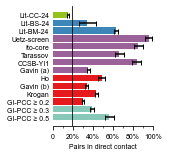

In [4]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.8, h=2.2)
ax.barh(list(fs.keys()),
         list(fs.values()),
        color=[COLOR_LIT_NB] +
              [COLOR_LIT] +
              [COLOR_LIT] +
              [COLOR_Y2H] * 5 +
              [COLOR_SYS_NB] * 4 +
              [COLOR_GI_PSN] * 3)

# overall fraction for whole dataset
ax.axvline(df['in_contact'].mean(), color='black', linestyle='-', linewidth=0.8)

ax.errorbar(y=list(fs.keys()),
             x=list(fs.values()),
             xerr=list(es.values()),
             color='black',
             capsize=2.5,
             fmt='none')
ax.invert_yaxis()
ax.set_xlabel('Pairs in direct contact')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0)

ax.set_xlim(0., 1.)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax.set_xticklabels(['0', '20%', '40%', '60%', '80%', '100%'])
ax.set_xticks(np.linspace(0, 1, 11), minor=True)

savefig('fraction_direct_contacts')

In [5]:
cocomplex_ds = ['Gavin (a)', 'Ho', 'Gavin (a)', 'Krogan', 'Lit-CC-24']
binary_ds = ['Uetz-screen', 'Ito-core', 'Tarassov', 'CCSB-YI1', 'Lit-BS-24', 'Lit-BM-24']
for ds in cocomplex_ds + binary_ds:
    if ds not in nws:
        raise UserWarning(ds, 'not in data')
df['binary'] = df.index.isin(set.union(*(v for k, v in nws.items() if k in binary_ds)))
df['non_binary'] = df.index.isin(set.union(*(v for k, v in nws.items() if k in cocomplex_ds)))
df['in_both'] = df['binary'] & df['non_binary']

a = (~df['in_both'] & df['binary'] & df['in_contact']).sum()
b = (~df['in_both'] & df['binary'] & ~df['in_contact']).sum()
c = (~df['in_both'] & df['non_binary'] & df['in_contact']).sum()
d = (~df['in_both'] & df['non_binary'] & ~df['in_contact']).sum()
print('contingency table:', a, b, c, d)
print('total n: ', a + b + c + d)
print('p = {:.2e}'.format(stats.fisher_exact([[a, b], [c, d]])[1]))
print('overall binary in direct contact: {:.2%}'.format(df.loc[df['binary'], 'in_contact'].mean()))
print('overall non-binary in direct contact: {:.2%}'.format(df.loc[df['non_binary'], 'in_contact'].mean()))

contingency table: 252 209 659 3795
total n:  4915
p = 1.12e-76
overall binary in direct contact: 62.03%
overall non-binary in direct contact: 21.27%
